In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import icd10 as icd10
import datacompy

In [2]:
df_raw = pd.read_csv("combined.csv",low_memory=False)
features= df_raw.columns.tolist()

In [3]:
df_raw.dropna(axis=1,how='all')
df = df_raw.fillna(0)

In [4]:
df_str = pd.DataFrame(df)
df_str['age'] = df['age'].apply(str)
age_NotSpecified = list(df_str[df_str['age'].str.contains('999')].index)
df = df.drop(index = age_NotSpecified, axis=1)
df['age'] = df['age'].apply(int)

## 1.5 Decoding the age:
#### 1. if the first digit is 1, then the last three digits represent the age under years.
#### 2. if the first digit is 2, then the last three digits represent the age under months.
#### 3. if the first digit is 4, then the last three digits represent the age under days.
#### 4. if the first digit is 5, then the last three digits represent the age under hours.
#### 5. if the first digit is 6, then the last three digits represent the age under minutes.
#### 6. if any three digits are 999, then the age is not speficied.

Here we filter out the index of keys with unspecified age, and get the index list to drop at next step.

In [5]:
df.loc[(df['age']>=1000)&(df['age']<2000),'age']= df['age'] - 1000
df.loc[(df['age']>=2000)&(df['age']<3000),'age']=(df['age']-2000)/12
df.loc[(df['age']>=4000)&(df['age']<5000),'age']=(df['age']-4000)/365
#Although we have people died when they were just a couple of hours old, we actually can ignore that since since they were that young, it is impossible for them to "commit a df"
df[(df['age']>=5000)&(df['age']<6000)]
df.loc[(df['age']>=5000)&(df['age']<6000),'age']=(df['age']-5000)/24/365
#I am so sorry that you died so young babe!
df[(df['age']>=6000)&(df['age']<7000)]
df.loc[(df['age']>=6000)&(df['age']<7000),'age']=(df['age']-6000)/60/24/365

We throw away rows with unspecified features.

In [6]:
df=df.loc[df['educ2003'] != 9]
df=df.loc[df['marstat'] != 'U']
df=df.loc[df['weekday'] != 9]
df=df.loc[df['placdth'] != 9]

In [7]:
df_suicide = df.loc[df['mandeath'] == 2]
from sklearn.utils import resample

df_not_suicide = df.loc[df['mandeath']!=2]
df_not_suicide=resample(df_not_suicide,replace=True,n_samples=len(df_suicide),random_state=42)

In [8]:
def ICD10_Categorize(df_in):

    all_record_list=[]
    for row in df_in.itertuples():
        all_rec=[]
        for col in range(int(getattr(row, 'ranum'))):
            all_rec.append(getattr(row,'record_'+str(col+1)))

        # all_record=(getattr(row, 'record_1'), getattr(row, 'record_2'), getattr(row, 'record_3'), 
        # getattr(row, 'record_4'), getattr(row, 'record_5'), getattr(row, 'record_6'), getattr(row, 'record_7'), 
        # getattr(row, 'record_8'), getattr(row, 'record_9'), getattr(row, 'record_10'),getattr(row, 'record_11'), 
        # getattr(row, 'record_12'), getattr(row, 'record_13'), getattr(row, 'record_14'), getattr(row, 'record_15'), 
        # getattr(row, 'record_16'), getattr(row, 'record_17'), getattr(row, 'record_18'), getattr(row, 'record_19'), 
        # getattr(row, 'record_20'))
        all_record_list.append(list(all_rec))
    
    all_cat_list=[]
    for row in df_in.itertuples():
        all_cat = []
        for col in range(int(getattr(row, 'ranum'))):

            code = icd10.find(getattr(row, 'record_'+str(col+1)))
            if code == None:
                break
            try:
                all_cat.append(code.block_description)
            except:
                all_cat.append(code.description)

    
        all_cat_list.append(list(all_cat))
   
    df_record = pd.DataFrame(all_record_list)
    df_record['all_in_one']=df_record[df_record.columns[0:]].apply(lambda x: ','.join(x[x!=0].astype(str)),axis=1)
    

    df_cat = pd.DataFrame(all_cat_list)
    df_cat.fillna(value=0,inplace= True)
    

    df_cat['all_cat']=df_cat[df_cat.columns[0:]].apply(lambda x: ';'.join(x[x!=0].astype(str)),axis=1)
    

    df_rec_cat=pd.concat([df_record['all_in_one'],df_cat['all_cat']],axis=1)

    df_out = pd.concat([df_in.reset_index(inplace=True),df_rec_cat], axis=1)

    df= df_in.reset_index(drop=True)

    return pd.concat([df,df_out],axis=1)


df_combined=ICD10_Categorize(df_suicide)
df_not_suicide=ICD10_Categorize(df_not_suicide)

In [9]:
icd_chapter=pd.DataFrame(icd10.chapters)
icd_chapter.rename(columns={0:'Chapter',1:"Block",2:"Description"},inplace=True)
all_chapter=icd_chapter['Chapter'].tolist()

In [10]:
df_all_blocks= pd.concat([df_combined,pd.DataFrame(columns=all_chapter)],sort=False)
df_all_blocks.fillna(value=0,inplace=True)

df_all_blocks_not_suicide= pd.concat([df_not_suicide,pd.DataFrame(columns=all_chapter)],sort=False)
df_all_blocks_not_suicide.fillna(value=0,inplace=True)

In [11]:
def chapter(df_in):

    for index, rows in df_in.iterrows():
        record_list=[]
        for i in range(1,int(rows['ranum']+1),1):
            record_list.append('record_'+str(i))
        #print(record_list)
        
        for rec in record_list:
            if(rows[rec]==0):
                break
            else:
                
                code = icd10.find(rows[rec])
                try:
                    chap_count = getattr(rows,code.chapter) + 1
                    df_in.at[index,code.chapter] = chap_count
                except:...
                
                
    return df_in
    

final_suicide=chapter(df_all_blocks)

final_not_suicide=chapter(df_all_blocks_not_suicide)

In [13]:
import scipy.stats as stats

stats.pearsonr(final_suicide['XX'],final_suicide['XIX'])

PearsonRResult(statistic=-0.09025830617413105, pvalue=0.0)

In [14]:
record_list=[]
for i in range(1,21,1):
    record_list.append('record_'+str(i))

final_suicide = final_suicide.drop(record_list,axis=1)

In [16]:
dict_chapter = {}
chapter_list = pd.DataFrame(icd10.chapters)

for i in chapter_list[0]:
    dict_chapter[i] = final_suicide[i].sum()

Text(0, 0.5, 'Occurance')

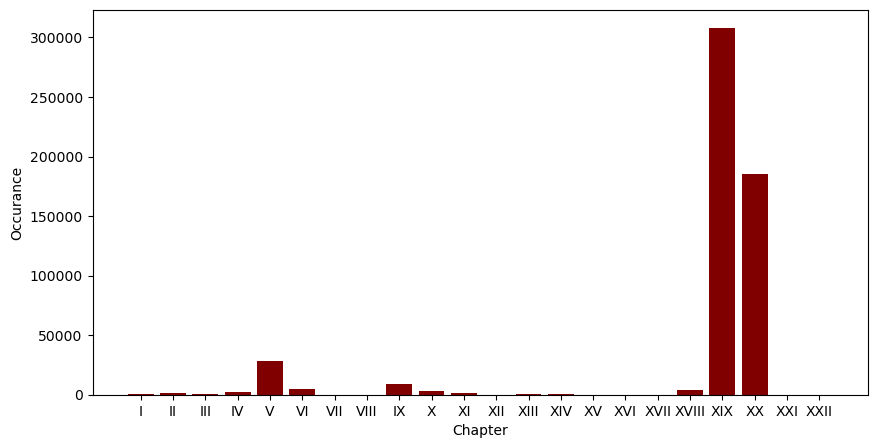

In [17]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(dict_chapter.keys(), dict_chapter.values(), color ='maroon')
plt.xlabel("Chapter")
plt.ylabel("Occurance")

T and S should be outlier because it is caused by the suicides.

X is the same

In [18]:
outlier = ['XX','XIX']

for key in outlier:
    del dict_chapter[key]

Text(0, 0.5, 'Occurance Values')

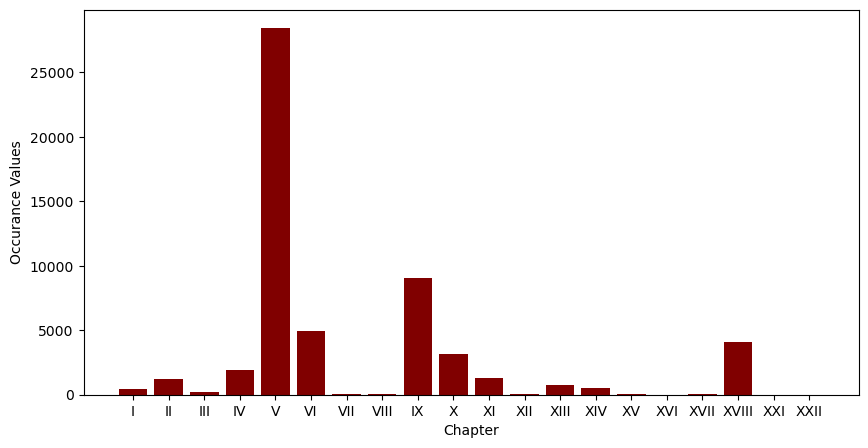

In [19]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(dict_chapter.keys(), dict_chapter.values(), color ='maroon')
plt.xlabel("Chapter")
plt.ylabel("Occurance Values")

In [20]:
final_suicide.to_csv(r'suicide.csv',index=False)
final_not_suicide.to_csv(r'NotSuicided.csv',index=False)